In [1]:
import sys
sys.path.append("../")
from plotting import CandlePlot
import pandas as pd

In [2]:
from technicals.patterns import apply_patterns

In [3]:
df = pd.read_pickle("../data/GBP_JPY_H1.pkl")

In [4]:
df_an = df[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c']].copy()

In [5]:
df_an.tail()

,time,mid_o,mid_h,mid_l,mid_c
37219,2021-12-30 19:00:00+00:00,155.312,155.444,155.274,155.444
37220,2021-12-30 20:00:00+00:00,155.442,155.470,155.289,155.312
37221,2021-12-30 21:00:00+00:00,155.317,155.382,155.286,155.382
37222,2021-12-30 22:00:00+00:00,155.353,155.381,155.282,155.329
37223,2021-12-30 23:00:00+00:00,155.336,155.360,155.284,155.310


In [ ]:
# direction = df_an.mid_c - df_an.mid_o
# body_size = abs(direction)
# direction = [1 if x >= 0 else -1 for x in direction]
# full_range = df_an.mid_h - df_an.mid_l
# body_perc = (body_size / full_range) * 100
# body_lower = df_an[['mid_c','mid_o']].min(axis=1)
# body_upper = df_an[['mid_c','mid_o']].max(axis=1)
# body_bottom_perc = ((body_lower - df_an.mid_l) / full_range) * 100
# body_top_perc = 100 - (((df_an.mid_h - body_upper) / full_range) * 100)

In [ ]:
# df_an['body_lower'] = body_lower
# df_an['body_upper'] = body_upper
# df_an['body_perc'] = body_perc
# df_an['body_bottom_perc'] = body_bottom_perc
# df_an['body_top_perc'] = body_top_perc
# df_an['full_range'] = full_range

In [6]:
df_an = apply_patterns(df_an)

In [11]:
HANGING_MAN_BODY = 15.0
HANGING_MAN_HEIGHT = 75.0
SHOOTING_STAR_HEIGHT = 25.0
SPINNING_TOP_MIN = 40.0
SPINNING_TOP_MAX = 60.0
MARUBOZU = 98.0
ENGULFING_FACTOR = 1.1

apply_marubozu = lambda x: x.body_perc > MARUBOZU

def apply_hanging_man(row):
    if row.body_bottom_perc > HANGING_MAN_HEIGHT:
        if row.body_perc < HANGING_MAN_BODY:
            return True
    return False

def apply_shooting_star(row):
    if row.body_top_perc < SHOOTING_STAR_HEIGHT:
        if row.body_perc < HANGING_MAN_BODY:
            return True
    return False

def apply_spinning_top(row):
    if row.body_top_perc < SPINNING_TOP_MAX:
        if row.body_bottom_perc > SPINNING_TOP_MIN:
            if row.body_perc < HANGING_MAN_BODY:
                return True
    return False

def apply_engulfing(row):
    if row.direction != row.direction_prev:
        if row.body_size > row.body_size_prev * ENGULFING_FACTOR:
            return True
    return False

TWEEZER_BODY = 15.0
TWEEZER_HL = 0.01
TWEEZER_TOP_BODY = 40.0
TWEEZER_BOTTOM_BODY = 60.0

def apply_tweezer_top(row):
    if abs(row.body_size_change) < TWEEZER_BODY:
        if row.direction == -1 and row.direction != row.direction_prev:
            if abs(row.low_change) < TWEEZER_HL and abs(row.high_change) < TWEEZER_HL:
                if row.body_top_perc < TWEEZER_TOP_BODY:
                    return True
    return False

def apply_tweezer_bottom(row):
    if abs(row.body_size_change) < TWEEZER_BODY:
        if row.direction == 1 and row.direction != row.direction_prev:
            if abs(row.low_change) < TWEEZER_HL and abs(row.high_change) < TWEEZER_HL:
                if row.body_bottom_perc > TWEEZER_BOTTOM_BODY:
                    return True
    return False

MORNING_STAR_PREV2_BODY = 90.0
MORNING_STAR_PREV_BODY = 10.0

def apply_morning_star(row, direction=1):
    if row.body_perc_prev_2 > MORNING_STAR_PREV2_BODY:
        if row.body_perc_prev < MORNING_STAR_PREV_BODY:
            if row.direction == direction and row.direction_prev_2 != direction:
                if direction == 1:
                    if row.mid_c > row.mid_point_prev_2:
                        return True
                else:
                    if row.mid_c < row.mid_point_prev_2:
                        return True
    return False

In [12]:
df_an['body_size_prev'] = df_an.body_size.shift(1)
df_an['direction_prev'] = df_an.direction.shift(1)
df_an['direction_prev_2'] = df_an.direction.shift(2)
df_an['body_perc_prev'] = df_an.body_perc.shift(1)
df_an['body_perc_prev_2'] = df_an.body_perc.shift(2)
df_an['HANGING_MAN'] = df_an.apply(apply_hanging_man, axis=1)
df_an['SHOOTING_STAR'] = df_an.apply(apply_shooting_star, axis=1)
df_an['SPINNING_TOP'] = df_an.apply(apply_spinning_top, axis=1)
df_an['MARUBOZU'] = df_an.apply(apply_marubozu, axis=1)
df_an['ENGULFING'] = df_an.apply(apply_engulfing, axis=1)
df_an['TWEEZER_TOP'] = df_an.apply(apply_tweezer_top, axis=1)
df_an['TWEEZER_BOTTOM'] = df_an.apply(apply_tweezer_bottom, axis=1)
df_an['MORNING_STAR'] = df_an.apply(apply_morning_star, axis=1)
df_an['EVENING_STAR'] = df_an.apply(apply_morning_star, axis=1, direction=-1)

In [17]:
df_an[df_an['EVENING_STAR'] == True]

,time,mid_o,mid_h,mid_l,mid_c,body_lower,body_upper,body_bottom_perc,body_top_perc,body_perc,...,body_perc_prev_2,HANGING_MAN,SHOOTING_STAR,SPINNING_TOP,MARUBOZU,ENGULFING,TWEEZER_TOP,TWEEZER_BOTTOM,MORNING_STAR,EVENING_STAR
3962,2016-08-25 01:00:00+00:00,133.144,133.179,133.018,133.018,133.018,133.144,0.000000,78.260870,78.260870,...,95.500000,False,False,False,False,True,False,False,False,True
8904,2017-06-13 01:00:00+00:00,139.270,139.436,139.128,139.202,139.202,139.270,24.025974,46.103896,22.077922,...,92.814371,False,False,False,False,False,False,False,False,True
13219,2018-02-21 19:00:00+00:00,150.360,150.502,150.124,150.171,150.171,150.360,12.433862,62.433862,50.000000,...,91.696751,False,False,False,False,True,False,False,False,True
15175,2018-06-15 06:00:00+00:00,146.788,146.819,146.635,146.654,146.654,146.788,10.326087,83.152174,72.826087,...,100.000000,False,False,False,False,True,False,False,False,True
26233,2020-03-26 21:00:00+00:00,133.752,133.778,133.044,133.091,133.091,133.752,6.403270,96.457766,90.054496,...,91.059908,False,False,False,False,False,False,False,False,True
27388,2020-06-03 01:00:00+00:00,136.900,137.010,136.462,136.504,136.504,136.900,7.664234,79.927007,72.262774,...,95.781250,False,False,False,False,False,False,False,False,True


In [14]:
import plotly.graph_objects as go

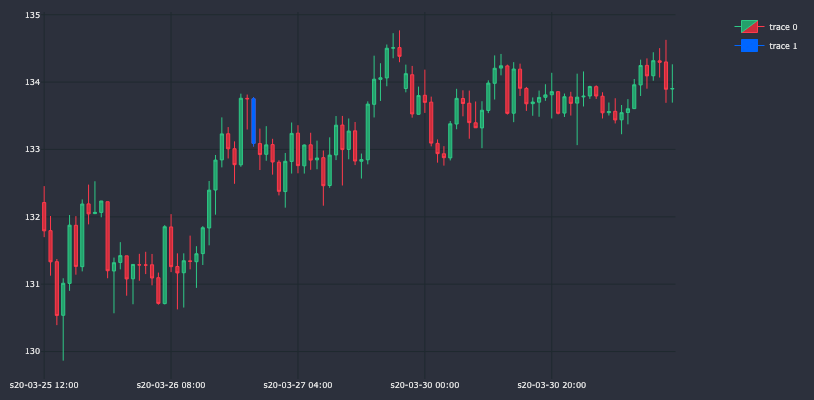

In [20]:
MARKER = '#0066FF'
dfp = df_an.iloc[26200:26300]
cp = CandlePlot(dfp, candles=True)
df_temp = cp.df_plot[cp.df_plot.EVENING_STAR==True]
cp.fig.add_trace(go.Candlestick(
                x=df_temp.sTime,
                open=df_temp.mid_o,
                high=df_temp.mid_h,
                low=df_temp.mid_l,
                close=df_temp.mid_c,
                line=dict(width=1), opacity=1,
                increasing_fillcolor=MARKER,
                decreasing_fillcolor=MARKER,
                increasing_line_color=MARKER,  
                decreasing_line_color=MARKER
            ))

cp.show_plot()